# Modelo de Machine Learning, aprendizaje supervisado

### Preparar datos, entrenar y evaluar modelo

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split

# 1. Preparar los datos

# Directorio que contiene las imágenes
data_dir = "../imagenes_entrenamiento"

# Tamaño de los lotes de datos
batch_size = 8

# Transformaciones que se aplican a las imágenes
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar las imágenes a 224x224 píxeles
    transforms.ToTensor(),  # Convertir las imágenes a tensores
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizar los colores
])

# Cargar las imágenes y asignar etiquetas automáticamente según los nombres de las carpetas
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Dividir el conjunto de datos en entrenamiento y validación
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear cargadores de datos para el entrenamiento y la validación
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 2. Entrenar el modelo

# Utilizar ResNet-18 preentrenada
#model = models.resnet18(pretrained=True) --> Por esta linea daba warning
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modificar la capa final para clasificar en 3 clases
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 3)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Número de épocas de entrenamiento
num_epochs = 5
for epoch in range(num_epochs):
    model.train()  # Establecer el modo de entrenamiento
    running_loss = 0.0
    for inputs, labels in train_loader:  # Iterar sobre los lotes de datos
        optimizer.zero_grad()  # Limpiar los gradientes
        outputs = model(inputs)  # Hacer la predicción
        loss = criterion(outputs, labels)  # Calcular la pérdida
        loss.backward()  # Propagar hacia atrás
        optimizer.step()  # Actualizar los parámetros
        running_loss += loss.item()
    print(f"Época [{epoch+1}/{num_epochs}], Pérdida: {running_loss/len(train_loader):.4f}")

# 3. Evaluar el modelo

model.eval()  # Establecer el modo de evaluación
correct = 0
total = 0
with torch.no_grad():  # Desactivar el cálculo de gradientes
    for inputs, labels in val_loader:  # Iterar sobre los lotes de datos de validación
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Obtener la clase con la mayor probabilidad
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Exactitud de validación: {100 * correct / total:.2f}%")

Época [1/5], Pérdida: 1.3220
Época [2/5], Pérdida: 0.8170
Época [3/5], Pérdida: 0.8804
Época [4/5], Pérdida: 0.5852
Época [5/5], Pérdida: 0.5149
Exactitud de validación: 60.00%


# Procesamiento de datos

### Predecir ya con el modelo entrenado
Se crea una nueva base de datos como resultado del analisis del modelo de machine learning.

In [12]:
import os
import pandas as pd
from PIL import Image
import random

# Función para generar un número aleatorio flotante de 2 dígitos dentro de un rango específico
def generar_peso_extra(clase_ropa):
    if clase_ropa == "normal":
        return round(random.uniform(0.5, 1.5), 2)
    elif clase_ropa == "mediana":
        return round(random.uniform(1.5, 2.5), 2)
    else:
        return round(random.uniform(2.5, 5), 2)

# Función para predecir la clase de ropa y crear un nuevo archivo de Excel
def predict_images(excel_file, new_excel_file):
    """Función para predecir la clase de todas las imágenes en un archivo de Excel y guardar los resultados en un nuevo archivo."""
    # Cargar el archivo de Excel en un DataFrame
    df = pd.read_excel(excel_file)

    # Iterar sobre cada fila del DataFrame
    for index, row in df.iterrows():
        image_path = row["IMAGEN_PASAJERO"]
        if pd.notnull(image_path) and os.path.isfile(image_path):
            # Verificar si la ruta es un archivo válido
            image = Image.open(image_path)
            image = transform(image).unsqueeze(0)
            model.eval()
            with torch.no_grad():
                output = model(image)
            _, predicted = torch.max(output, 1)
            class_name = dataset.classes[predicted.item()]
            print(f'La persona en la imagen "{os.path.basename(image_path)}" tiene "{class_name}" ropa.')

            # Generar el peso extra aleatorio según la clase de ropa
            peso_extra = generar_peso_extra(class_name)

            # Actualizar las columnas "ROPA" y "PESO_KG_EXTRA" en el DataFrame
            df.loc[index, "ROPA"] = class_name
            df.loc[index, "PESO_KG_EXTRA"] = peso_extra

    # Guardar el nuevo DataFrame en un nuevo archivo de Excel
    df.to_excel(new_excel_file, index=False)

# Ruta hacia la base de datos de los pasajeros
predict_images("../pasajeros/bd_pasajeros.xlsx", "../resultado_analisis/bd_resultados.xlsx")

La persona en la imagen "pasajero1.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero2.webp" tiene "normal" ropa.
La persona en la imagen "pasajero3.webp" tiene "mucha" ropa.
La persona en la imagen "pasajero4.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero5.webp" tiene "mucha" ropa.
La persona en la imagen "pasajero6.webp" tiene "mucha" ropa.
La persona en la imagen "pasajero7.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero8.jpg" tiene "mucha" ropa.
La persona en la imagen "pasajero9.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero10.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero11.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero12.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero13.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero14.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero15.jpg" tiene "normal" ropa.
La persona en la imagen "pasajero16.jpg" tiene "mucha" ropa.
La persona en la ima

# Analisís del cruze final de datos. 

### Objetivo de este analisis: 
es mostrar un analisis sencillo pero esclarecedor de los datos, tomando en cuenta el cruze final de las dos bases de datos mas importantes, es decir, la del trafico aereo y la de pasajeros.


C:\Users\iEspa\AppData\Local\Temp\ipykernel_9376\545147077.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({


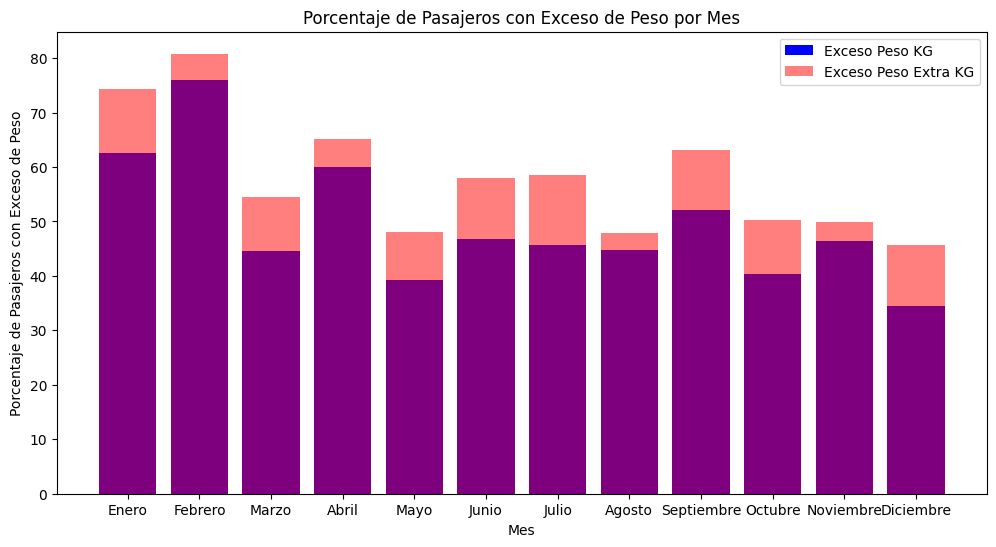

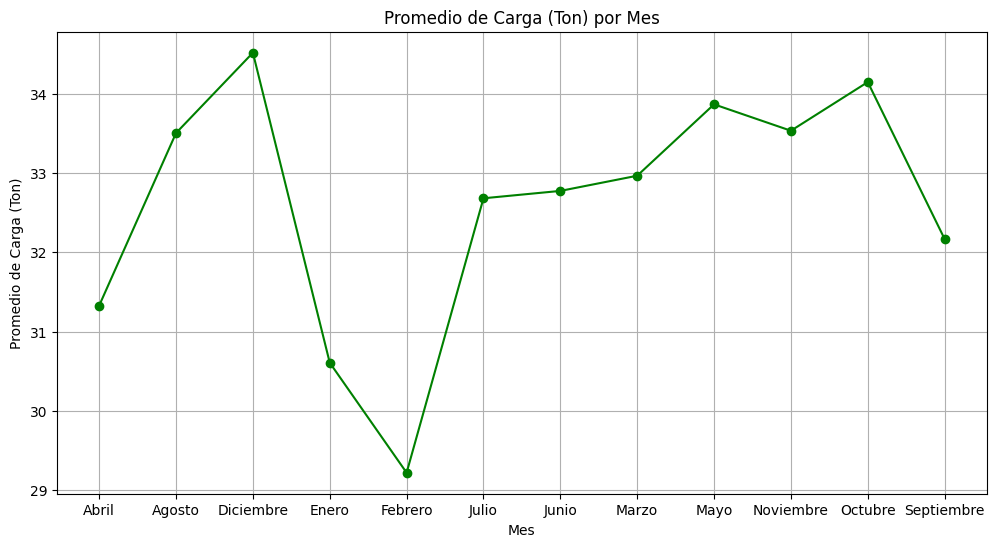

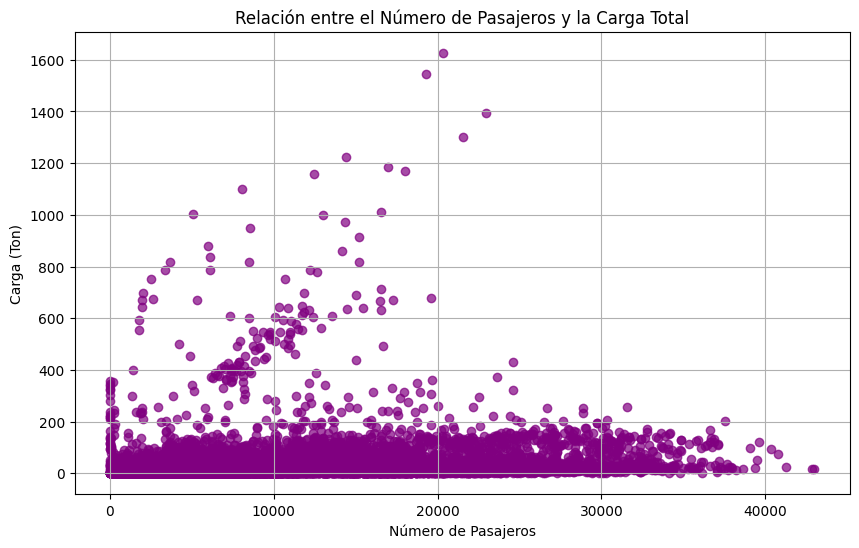

In [11]:
# Importar las librerías necesarias
import pandas as pd
import matplotlib.pyplot as plt
import os

# Definir la ruta del archivo final
folder_1 = '../db_Final'
archivo_final = os.path.join(folder_1, 'db_Final.xlsx')

# Cargar el archivo Excel final
df_final = pd.read_excel(archivo_final)

# Porcentaje de Exceso de Peso por Mes
porcentaje_exceso_peso = pd.DataFrame(columns=['Mes', 'Exceso_peso_kg', 'Exceso_peso_extra_kg'])

for mes in df_final['Mes'].unique():
    total_pasajeros = len(df_final[df_final['Mes'] == mes])
    exceso_peso_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_kg'] == True)]) / total_pasajeros * 100
    exceso_peso_extra_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_extra_kg'] == True)]) / total_pasajeros * 100
    
    porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({
        'Mes': [mes],
        'Exceso_peso_kg': [exceso_peso_kg],
        'Exceso_peso_extra_kg': [exceso_peso_extra_kg]
    })], ignore_index=True)

# Ordenar los meses para que aparezcan en orden cronológico
porcentaje_exceso_peso['Mes'] = pd.Categorical(porcentaje_exceso_peso['Mes'], categories=[
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
], ordered=True)
porcentaje_exceso_peso = porcentaje_exceso_peso.sort_values('Mes')

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_kg'], color='b', label='Exceso Peso KG')
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_extra_kg'], color='r', alpha=0.5, label='Exceso Peso Extra KG')

# Añadir etiquetas y título
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Pasajeros con Exceso de Peso')
plt.title('Porcentaje de Pasajeros con Exceso de Peso por Mes')
plt.legend()

# Mostrar el gráfico
plt.show()

promedio_carga_por_mes = df_final.groupby('Mes')['CARGA (Ton)'].mean()

plt.figure(figsize=(12, 6))
plt.plot(promedio_carga_por_mes.index, promedio_carga_por_mes.values, marker='o', linestyle='-', color='green')
plt.xlabel('Mes')
plt.ylabel('Promedio de Carga (Ton)')
plt.title('Promedio de Carga (Ton) por Mes')
plt.grid(True)
plt.show()

# Relación entre el Número de Pasajeros y la Carga Total
plt.figure(figsize=(10, 6))
plt.scatter(df_final['PASAJEROS'], df_final['CARGA (Ton)'], alpha=0.7, color='purple')
plt.xlabel('Número de Pasajeros')
plt.ylabel('Carga (Ton)')
plt.title('Relación entre el Número de Pasajeros y la Carga Total')
plt.grid(True)
plt.show()

C:\Users\iEspa\AppData\Local\Temp\ipykernel_22240\2658428275.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({


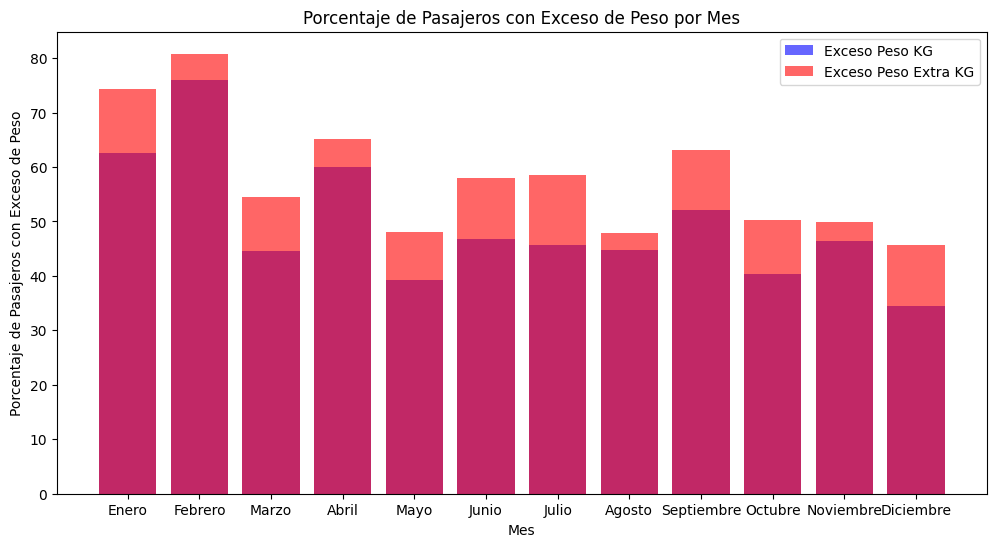

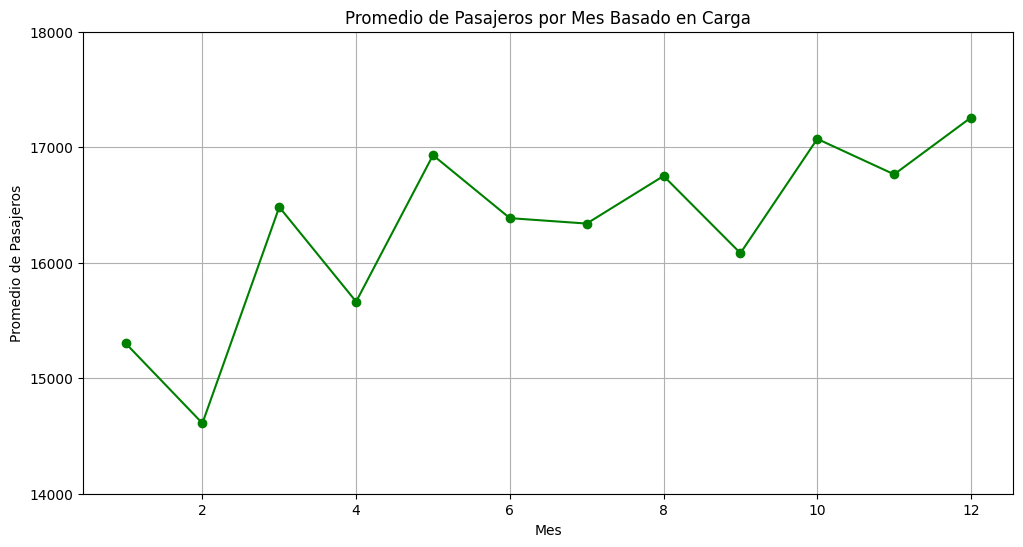

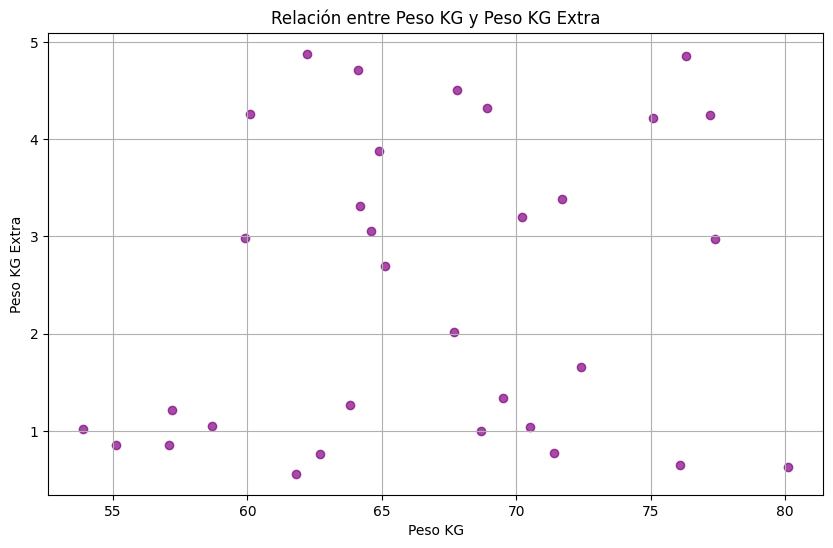

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os


folder_1 = '../db_Final'
folder_2 = '../resultado_analisis'
archivo_final = os.path.join(folder_1, 'db_Final.xlsx')
archivo_resultados = os.path.join(folder_2, 'bd_resultados.xlsx')
archivo_filtrado = os.path.join(folder_1, 'BD_Trafico_aereo_filtrado.xlsx')


df_final = pd.read_excel(archivo_final)
df_resultados = pd.read_excel(archivo_resultados)
df_filtrado = pd.read_excel(archivo_filtrado)

# Porcentaje de Exceso de Peso por Mes
porcentaje_exceso_peso = pd.DataFrame(columns=['Mes', 'Exceso_peso_kg', 'Exceso_peso_extra_kg'])

for mes in df_final['Mes'].unique():
    total_pasajeros = len(df_final[df_final['Mes'] == mes])
    exceso_peso_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_kg'] == True)]) / total_pasajeros * 100
    exceso_peso_extra_kg = len(df_final[(df_final['Mes'] == mes) & (df_final['Exceso_peso_extra_kg'] == True)]) / total_pasajeros * 100
    
    porcentaje_exceso_peso = pd.concat([porcentaje_exceso_peso, pd.DataFrame({
        'Mes': [mes],
        'Exceso_peso_kg': [exceso_peso_kg],
        'Exceso_peso_extra_kg': [exceso_peso_extra_kg]
    })], ignore_index=True)
porcentaje_exceso_peso['Mes'] = pd.Categorical(porcentaje_exceso_peso['Mes'], categories=[
    "Enero", "Febrero", "Marzo", "Abril", "Mayo", "Junio",
    "Julio", "Agosto", "Septiembre", "Octubre", "Noviembre", "Diciembre"
], ordered=True)
porcentaje_exceso_peso = porcentaje_exceso_peso.sort_values('Mes')

plt.figure(figsize=(12, 6))
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_kg'], color='b', alpha=0.6, label='Exceso Peso KG')
plt.bar(porcentaje_exceso_peso['Mes'], porcentaje_exceso_peso['Exceso_peso_extra_kg'], color='r', alpha=0.6, label='Exceso Peso Extra KG')
plt.xlabel('Mes')
plt.ylabel('Porcentaje de Pasajeros con Exceso de Peso')
plt.title('Porcentaje de Pasajeros con Exceso de Peso por Mes')
plt.legend()
plt.show()

# Promedio de Pasajeros por Mes Basado en Carga

promedio_pasajeros_por_mes = []

for mes in range(1, 13):
    df_mes = df_filtrado[df_filtrado['Mes'] == mes]
    suma_mes = int(((df_mes["CARGA (Ton)"] * 1000).mean()) / 2)
    promedio_pasajeros_por_mes.append({'Mes': mes, 'Promedio_Pasajeros': suma_mes})


promedio_pasajeros_df = pd.DataFrame(promedio_pasajeros_por_mes)
promedio_pasajeros_df['Mes'] = pd.Categorical(promedio_pasajeros_df['Mes'], categories=range(1, 13), ordered=True)
promedio_pasajeros_df = promedio_pasajeros_df.sort_values('Mes')


plt.figure(figsize=(12, 6))
plt.plot(promedio_pasajeros_df['Mes'], promedio_pasajeros_df['Promedio_Pasajeros'], marker='o', linestyle='-', color='green')
plt.xlabel('Mes')
plt.ylabel('Promedio de Pasajeros')
plt.ylim(14000, 18000) 
plt.yticks(range(14000, 18001, 1000))
plt.title('Promedio de Pasajeros por Mes Basado en Carga')
plt.grid(True)
plt.show()

# Relación entre el Número de Pasajeros y el Peso Total (PESO_KG y PESO_KG_EXTRA)
peso_total = df_resultados['PESO_KG'].sum()
peso_extra_total = df_resultados['PESO_KG_EXTRA'].sum()

plt.figure(figsize=(10, 6))
plt.scatter(df_resultados['PESO_KG'], df_resultados['PESO_KG_EXTRA'], alpha=0.7, color='purple')
plt.xlabel('Peso KG')
plt.ylabel('Peso KG Extra')
plt.title('Relación entre Peso KG y Peso KG Extra')
plt.grid(True)
plt.show()

# Crea grafico para relacion por mes entre peso extra de pasajeros en el avion vs el peso normal y su diferencia con el peso promedio del avion.

sumas_por_mes = df_final.groupby('Mes')[['PESO_P_AVION', 'PESO_EXTRA_AVION']].sum()

plt.figure(figsize=(12, 6))
sumas_por_mes.plot(kind='bar', color=['blue', 'orange'])
plt.xlabel('Mes')
plt.ylabel('Suma Total')
plt.title('Comparativa entre PESO_P_AVION y PESO_EXTRA_AVION por Mes')
plt.xticks(rotation=45)
plt.legend(title='Tipo de Peso')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()